# Bus Stops in Buenos Aires (CABA) - EDA


## 1. Introduction

In this notebook I explore the distribution of bus stops in Buenos Aires (CABA). I use the cleaned layers from the data cleaning step (stops, streets, comunas, barrios) to get a basic overview, compare areas, and spot patterns on maps.

The goal here is not to build a model, but to understand where stops are concentrated, how coverage looks across the city, and which streets/lines stand out.

### 1.2 Questions/Objectives:

- How many stops are there in total, and how are they distributed across communes and neighborhoods?
- Which areas concentrate the highest number of stops?
- Which comunas and barrios have the highest stop density (stops per km²)?
- Which streets concentrate the highest number of bus stops, and where are these corridors located?
- Which bus lines have the most stops, and which comunas/barrios have the most distinct lines?
- Where are the highest-connectivity stop areas in the city (based on distinct bus lines)?

## 6. Lines & coverage
### 6.1 Lines with most stops
### 6.2 Comunas/barrios with most distinct lines
### 6.3 (Optional) Stop areas served by most lines (clusters)


## 2. Setup:

### Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

### Initial settings

In [2]:
%matplotlib inline
sys.path.append(str(Path.cwd().parent / "src"))
PROJECT_ROOT = Path.cwd().parent
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"

### Loading processed Data:

In [3]:
stops = gpd.read_file(PROCESSED_PATH / "stops.gpkg")
calles = gpd.read_file(PROCESSED_PATH / "calles.gpkg")
comunas = gpd.read_file(PROCESSED_PATH / "comunas.gpkg")
barrios = gpd.read_file(PROCESSED_PATH / "barrios.gpkg")

## 3. Overview

In this section I build a basic overview of the datasets. I start with simple checks and summary tables, then I look at how stops are distributed across comunas and barrios, and finally I use a density map to highlight where stops are more concentrated in the city. The goal here is not to be exhaustive, but to confirm that the dataset looks reasonable and ready for spatial aggregation.

### 3.1 Quick look

Before jumping into plots, I will do a quick check of shapes, CRS, geometry types and a few key values. This helps catch obvious issues early (missing values, wrong CRS, out-of-range codes).


In [4]:
aux_mapp = {"stops": stops, "calles": calles, "comunas": comunas, "barrios": barrios}
# Shapes
print("Shapes")
for name, gdf in aux_mapp.items():
    print(f"{name}: {gdf.shape}")


Shapes
stops: (6961, 12)
calles: (2742, 4)
comunas: (15, 5)
barrios: (48, 5)


In [5]:
# CRS
print("CRS")
for name, gdf in aux_mapp.items():
    print(f"{name}: {gdf.crs}")

CRS
stops: EPSG:4326
calles: EPSG:4326
comunas: EPSG:4326
barrios: EPSG:4326


In [6]:
# Geometry types
print("Geometry types")
for name, gdf in aux_mapp.items():
    print(f"\n{name}")
    print(gdf.geometry.geom_type.value_counts())

Geometry types

stops
Point    6961
Name: count, dtype: int64

calles
MultiLineString    2742
Name: count, dtype: int64

comunas
MultiPolygon    15
Name: count, dtype: int64

barrios
Polygon    48
Name: count, dtype: int64


In [7]:
# Bounds (sanity check)
print("Bounds (total_bounds)")
for name, gdf in aux_mapp.items():
    print(f"{name}: {gdf.total_bounds}")

Bounds (total_bounds)
stops: [-58.5304892 -34.7006587 -58.34234   -34.53648  ]
calles: [-58.5324417  -34.70574495 -58.34190732 -34.52947415]
comunas: [-58.53151731 -34.70535548 -58.33515706 -34.52649644]
barrios: [-58.53151731 -34.70535548 -58.33515706 -34.52649644]


In [8]:
# Missing values (key fields)
key_cols = ["calle", "direccion", "barrio", "comuna", "n_lines", "geometry"]
print("Percentage of missing values in stops")
display(stops[key_cols].isna().mean().mul(100).sort_values(ascending=False))

Percentage of missing values in stops


barrio       0.014366
calle        0.000000
direccion    0.000000
comuna       0.000000
n_lines      0.000000
geometry     0.000000
dtype: float64

In [9]:
# Basic counts / ranges
print("Basic checks")
print("Total stops:", len(stops))
print("Distinct comunas (stops):", stops["comuna"].nunique())
print("Distinct barrios (stops):", stops["barrio"].nunique())

Basic checks
Total stops: 6961
Distinct comunas (stops): 15
Distinct barrios (stops): 48


#### Quick conclusions
All DataFrames share the same CRS (EPSG:4326) and geometry types match what I expect (stops as points, streets as multilines, comunas and barrios as multipolygons/polygons). The stops dataset is basically complete: all key fields are non-missing, and `barrio` has only a negligible amount of missing values, around 0.01%.

I expected coordinates to fall roughly within CABA (around lon -59 to -58 and lat -35 to -34), and the bounds match this range, so there are no obvious outliers far away from the city.

The dataset also matches the official reference counts (15 comunas and 48 barrios).

### 3.2 Stops by comuna

Here I count how many stops fall in each comuna. This is a simple baseline that helps me see how stops are distributed across the main administrative units of the city. At this stage I focus on raw counts, knowing that larger comunas may naturally contain more stops.

In [10]:
stops_by_comuna = stops.groupby("comuna").size().rename("n_stops").reset_index()
comunas = comunas.merge(stops_by_comuna, on="comuna", how="left")
comunas["n_stops"] = comunas["n_stops"].fillna(0)

comunas[["comuna","n_stops"]].sort_values(by="n_stops", ascending=False)

,comuna,n_stops
0,1,939
3,4,752
14,15,531
13,14,489
8,9,478
11,12,476
2,3,438
7,8,405
6,7,401
10,11,390


This chart shows the number of bus stops aggregated by comuna. I use it as a first overview to compare how stops are distributed across the main administrative units of the city.

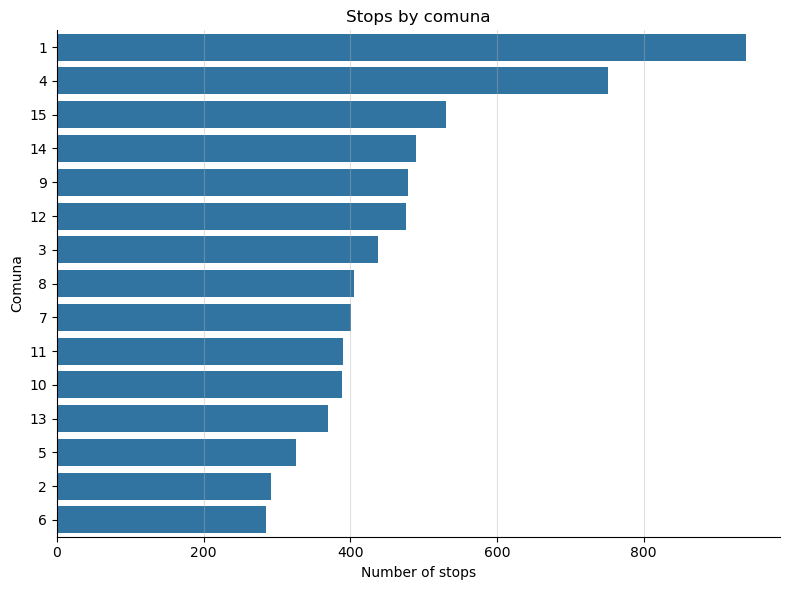

In [64]:
comuna_plot = comunas.copy().sort_values(by="n_stops", ascending=False)
comuna_plot["comuna"] = comuna_plot["comuna"].astype(str)

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(ax=ax, data=comuna_plot, x="n_stops", y="comuna")
plt.title("Stops by comuna")
plt.xlabel("Number of stops")
plt.ylabel("Comuna")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", alpha=0.4)
plt.tight_layout()


Finally, I map the counts to see the spatial pattern and confirm it matches what I expect visually.

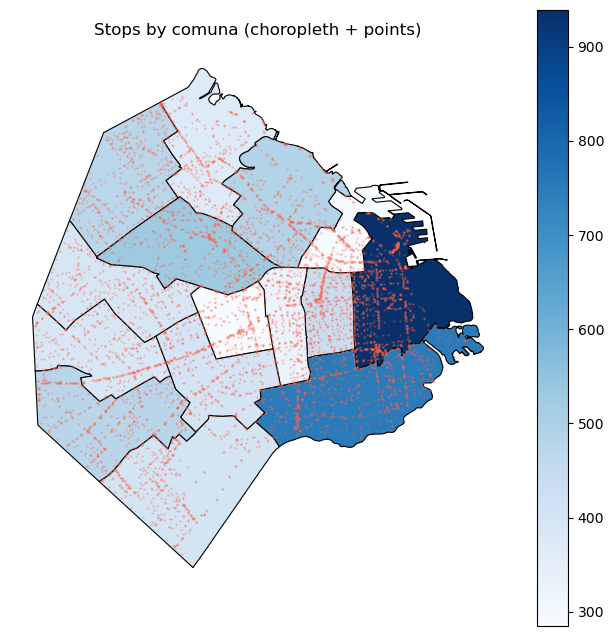

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

comunas.plot(ax=ax, column="n_stops", cmap="Blues", figsize=(6, 6), edgecolor="black", linewidth=0.8, legend=True)
stops.plot(ax=ax, markersize=0.5, color="tomato", alpha=0.3)
ax.set_title("Stops by comuna (choropleth + points)")
ax.set_axis_off()

Comuna 1 has the highest number of stops in this dataset. This is expected, since it covers a central area with high activity and many transit connections.

On the other hand, the comunas with the lowest stop counts may reflect lower stop density and/or more spread-out land use. I will confirm this later by looking at stops per km² (because raw counts can be misleading if the area is larger).

To add some context, I list the barrios included in the highest and lowest comunas (based on the official comunas layer).

In [13]:
top_comuna = comunas.loc[comunas["n_stops"].idxmax()]
bottom_comuna = comunas.loc[comunas["n_stops"].idxmin()]

display(top_comuna[["comuna", "barrios", "n_stops"]])
display(bottom_comuna[["comuna", "barrios", "n_stops"]])

comuna                                                     1
barrios    CONSTITUCION SAN TELMO MONSERRAT RETIRO PUERTO...
n_stops                                                  939
Name: 0, dtype: object

comuna             6
barrios    CABALLITO
n_stops          285
Name: 5, dtype: object

### 3.3 Stops by barrio

I repeat the same aggregation at the barrio level. Barrios provide a more detailed view than comunas, but they also vary a lot in size, so counts alone can be misleading. Still, raw counts are useful as a first pass to spot which neighborhoods concentrate more stops in absolute terms.

In [14]:
stops_by_barrio = stops.groupby("barrio").size().rename("n_stops").reset_index()
barrios = barrios.merge(stops_by_barrio,left_on="nombre",right_on="barrio",how="left")
barrios["n_stops"] = barrios["n_stops"].fillna(0)
barrios = barrios.drop(columns="barrio")

display(barrios.sort_values(by="n_stops", ascending=False)[["nombre", "n_stops"]].head(10))

display(barrios.sort_values(by="n_stops", ascending=False)[["nombre", "n_stops"]].tail(10))

,nombre,n_stops
20,PALERMO,488.0
2,BALVANERA,328.0
27,RECOLETA,300.0
7,CABALLITO,286.0
12,FLORES,280.0
3,BARRACAS,269.0
28,RETIRO,258.0
11,CONSTITUCION,221.0
4,BELGRANO,219.0
1,ALMAGRO,210.0


,nombre,n_stops
38,VILLA GRAL MITRE,0.0
39,VILLA LUGANO,0.0
40,VILLA LURO,0.0
41,VILLA ORTUZAR,0.0
42,VILLA PUEYRREDON,0.0
43,VILLA REAL,0.0
44,VILLA RIACHUELO,0.0
45,VILLA SANTA RITA,0.0
46,VILLA SOLDATI,0.0
47,VILLA URQUIZA,0.0


This chart displays the top 15 barrios with the highest number of bus stops. It provides a quick overview of where stops are most concentrated in absolute terms.

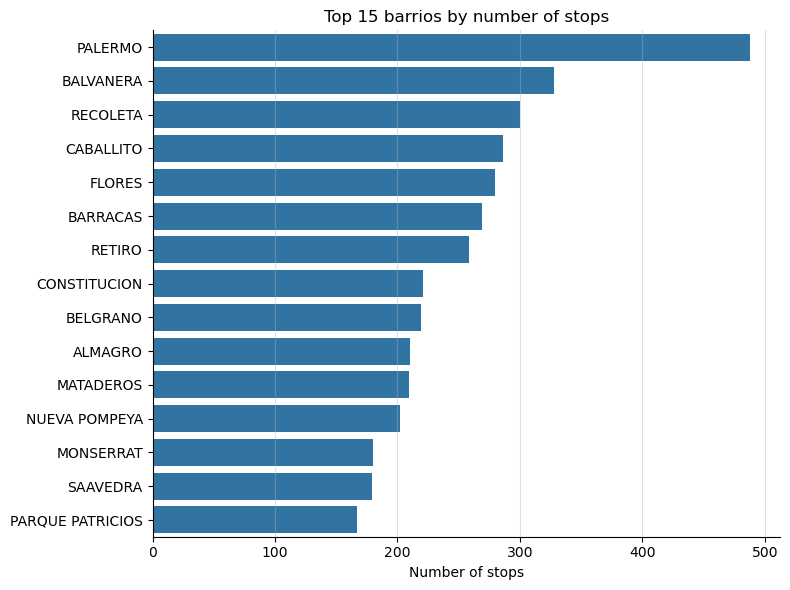

In [63]:
top_n = 15
barrios_plot = barrios.sort_values(by="n_stops", ascending=False).head(top_n)

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(data=barrios_plot, y="nombre", x="n_stops")
plt.title(f"Top {top_n} barrios by number of stops")
plt.xlabel("Number of stops")
plt.ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", alpha=0.4)
plt.tight_layout()


Next, I map the stop counts by barrio. This adds spatial context and helps confirm whether the highest counts are concentrated in specific parts of the city.

I join the stop counts to the barrios layer so I can plot them as a choropleth.

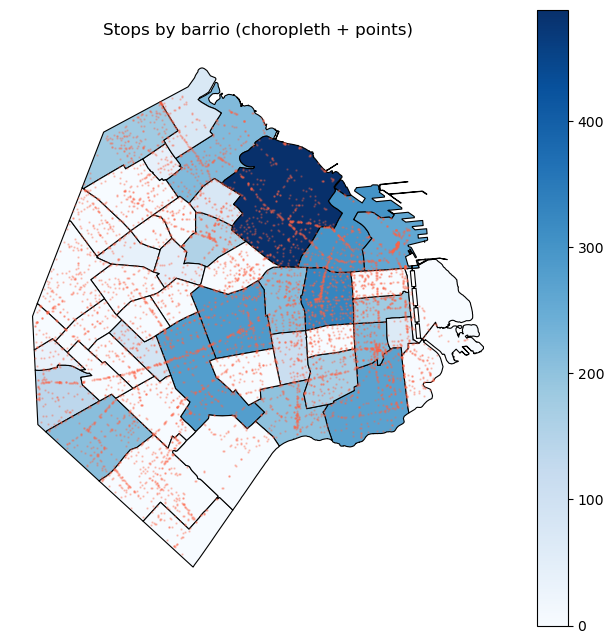

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

barrios.plot(ax=ax, column="n_stops", cmap="Blues", figsize=(6, 6), edgecolor="black", linewidth=0.8, legend=True)
stops.plot(ax=ax, markersize=0.5, color="tomato", alpha=0.3)
ax.set_title("Stops by barrio (choropleth + points)")
ax.set_axis_off()

At this stage I only look at raw counts. In the next section I normalize by area (stops per km²), because larger barrios can naturally have more stops.

### 3.4 Density map (hexbin)

To complement the administrative aggregations, I also use a hexbin map as a more “continuous” view of stop concentration. For this I reproject the data to a metric CRS (UTM 21S, EPSG:32721), so hexagon sizes and distances make sense in meters. The hexbin gives me a quick overview of hotspots without relying on neighborhood boundaries.

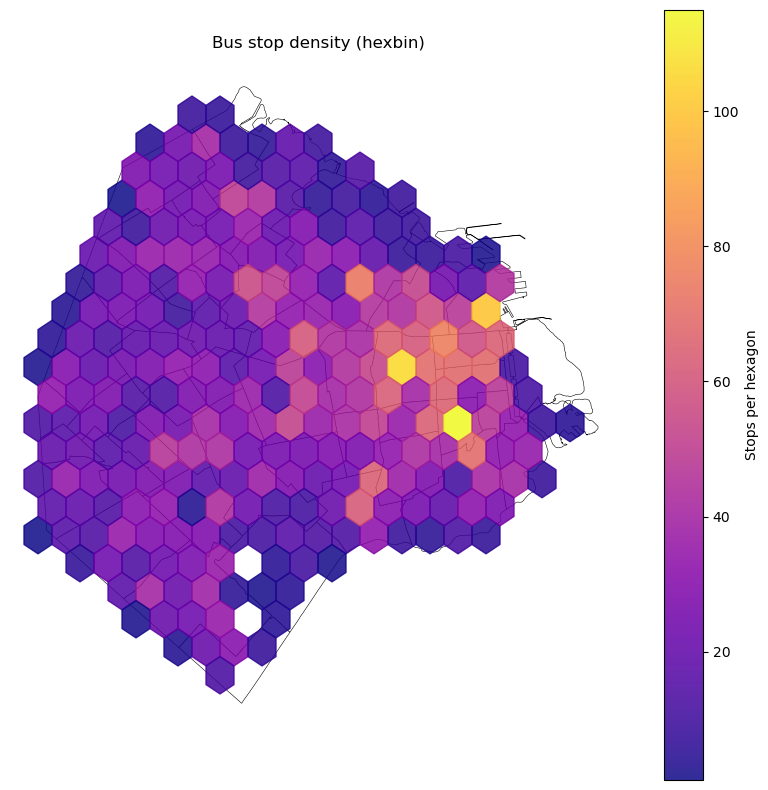

In [17]:
crs_m = "EPSG:32721"

stops_m = stops.to_crs(crs_m)
barrios_m = barrios.to_crs(crs_m)

x = stops_m.geometry.x
y = stops_m.geometry.y

fig, ax = plt.subplots(figsize=(8, 8))

# base
barrios_m.plot(ax=ax, facecolor="white", edgecolor="black", linewidth=0.4)

# stable extent (bbox from CABA)
minx, miny, maxx, maxy = barrios_m.total_bounds

hb = ax.hexbin(x,y,gridsize=20,extent=(minx, maxx, miny, maxy),mincnt=1,cmap="plasma",alpha=0.85)

fig.colorbar(hb, ax=ax, label="Stops per hexagon")
ax.set_title("Bus stop density (hexbin)")
ax.set_axis_off()
plt.tight_layout()


The resulting hexbin map offers a high-level view of bus stop density across CABA, good for an exploratory overview.

## 4. Stops density

Both the comunas and barrios layers already include an official **area** field (in m²).
The official `area` field is provided in square meters (m²). I convert it to square kilometers (km²) by dividing by 1,000,000, since 1 km² = 1,000,000 m².

In [18]:
comunas["area_km2"] = comunas["area"] / 1000000
barrios["area_km2"] = barrios["area"] / 1000000

### 4.1 Area (km²) by comuna and barrio

Before computing stop density, I look at the distribution of areas for comunas and barrios. This is important context: a large area can inflate raw stop counts, and barrios in particular can vary a lot in size. This check helps justify why stops per km² is a more comparable metric than simple counts.

Here I print a few summary statistics (min/median/mean/max) for the area of comunas and barrios. This gives me a quick sense of how different these administrative units are in size.

In [19]:
print("Comunas area_km2 (min/median/mean/max):",
      comunas["area_km2"].min(),
      comunas["area_km2"].median(),
      comunas["area_km2"].mean(),
      comunas["area_km2"].max())

print("Barrios area_km2 (min/median/mean/max):",
      barrios["area_km2"].min(),
      barrios["area_km2"].median(),
      barrios["area_km2"].mean(),
      barrios["area_km2"].max())

Comunas area_km2 (min/median/mean/max): 6.38599208 14.32289813 13.628204316 22.23309659
Barrios area_km2 (min/median/mean/max): 1.2322702700000001 3.679709125 4.249879914583333 15.92258617


As a quick check, I will look at the largest and smallest comunas/barrios by area, since raw stop counts can be influenced by how big the area is.

In [20]:
display(comunas[["comuna", "area_km2"]].sort_values("area_km2", ascending=False).head(5))
display(comunas[["comuna", "area_km2"]].sort_values("area_km2", ascending=False).tail(5))

display(barrios[["nombre", "area_km2"]].sort_values("area_km2", ascending=False).head(10))
display(barrios[["nombre", "area_km2"]].sort_values("area_km2", ascending=False).tail(10))


,comuna,area_km2
7,8,22.233097
3,4,21.690647
0,1,17.801036
8,9,16.505307
13,14,15.922564


,comuna,area_km2
6,7,12.422902
5,6,6.851030
4,5,6.660604
1,2,6.433392
2,3,6.385992


,nombre,area_km2
20,PALERMO,15.922586
39,VILLA LUGANO,9.296143
46,VILLA SOLDATI,8.690726
12,FLORES,8.590785
4,BELGRANO,8.060009
3,BARRACAS,7.955145
15,MATADEROS,7.398180
7,CABALLITO,6.851030
27,RECOLETA,6.433406
37,VILLA DEVOTO,6.404446


,nombre,area_km2
45,VILLA SANTA RITA,2.153691
0,AGRONOMIA,2.122170
11,CONSTITUCION,2.101995
30,SAN CRISTOBAL,2.043711
41,VILLA ORTUZAR,1.853802
34,VERSALLES,1.406834
23,PARQUE CHAS,1.385412
43,VILLA REAL,1.334146
9,COGHLAN,1.279951
32,SAN TELMO,1.232270


This plot shows the official area of each comuna. I include it as context, since comunas with larger area can naturally have more stops in raw counts, which is why I later focus on stops per km².

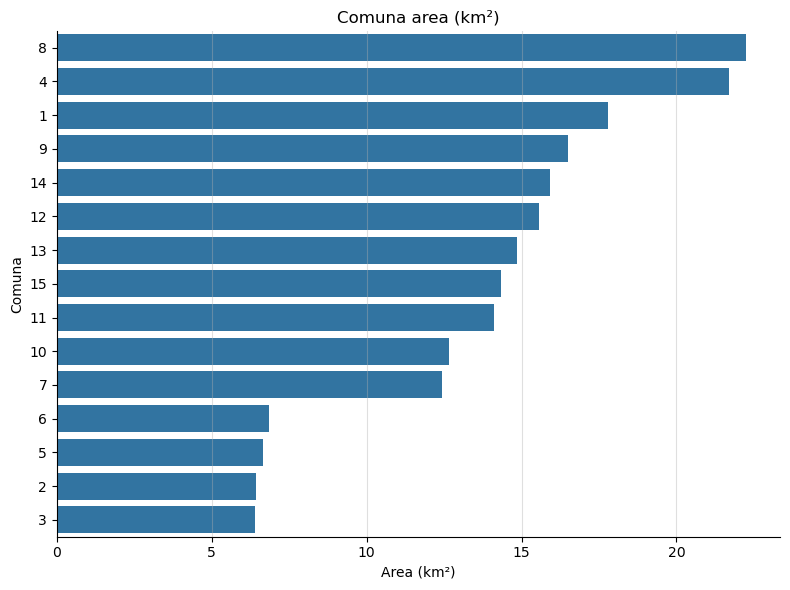

In [62]:
df_area = comunas[["comuna", "area_km2"]].sort_values("area_km2", ascending=False)
df_area["comuna"] = df_area["comuna"].astype(str)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=df_area, y="comuna", x="area_km2")
plt.title("Comuna area (km²)")
plt.xlabel("Area (km²)")
plt.ylabel("Comuna")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", alpha=0.4)
plt.tight_layout()

### 4.2 Stops density (stops per km²) by comuna and barrio

Here I compute stop density as n_stops / area_km2. I start with an overall baseline for CABA (total stops divided by total area), and then break it down by comuna and barrio. This makes comparisons fairer, especially across units with very different sizes.

In [22]:
total_stops = stops.shape[0]
caba_area = comunas["area_km2"].sum()
stops_per_km2_caba = total_stops / caba_area

print(f"Overall stop density in CABA: {stops_per_km2_caba:.2f} stops per km²")

Overall stop density in CABA: 34.05 stops per km²


#### 4.2.1 Stops density by comuna

At the comuna level, stop density highlights which areas have relatively high stop coverage once size is taken into account. This is often more informative than raw counts, because it separates “large comuna” effects from genuine concentration.

In [23]:
comunas["stops_per_km2"] = comunas["n_stops"] / comunas["area_km2"]
comunas[["comuna","area_km2","n_stops","stops_per_km2"]].sort_values("stops_per_km2", ascending=False)

,comuna,area_km2,n_stops,stops_per_km2
2,3,6.385992,438,68.587620
0,1,17.801036,939,52.749738
4,5,6.660604,326,48.944512
1,2,6.433392,292,45.388189
5,6,6.851030,285,41.599587
14,15,14.322898,531,37.073503
3,4,21.690647,752,34.669321
6,7,12.422902,401,32.279092
9,10,12.656558,389,30.735054
13,14,15.922564,489,30.711135


This chart ranks comunas by stop density, measured as stops per km².
Unlike raw counts, this view highlights relative concentration by accounting for differences in area.

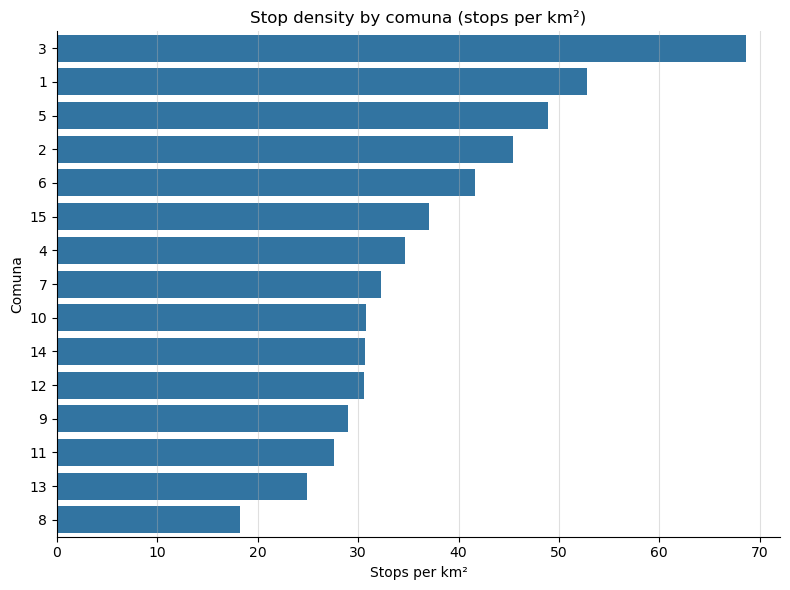

In [61]:
comunas_plot = comunas.copy().sort_values(by="stops_per_km2", ascending=False)
comunas_plot["comuna"] = comunas_plot["comuna"].astype(str)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(ax=ax, data=comunas_plot, y="comuna", x="stops_per_km2")
plt.title("Stop density by comuna (stops per km²)")
plt.xlabel("Stops per km²")
plt.ylabel("Comuna")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", alpha=0.4)
plt.tight_layout()


This map shows stop density by comuna, measured as the number of stops per square kilometer.
By normalizing stop counts by area, the choropleth highlights relative differences in stop concentration across comunas rather than absolute totals.

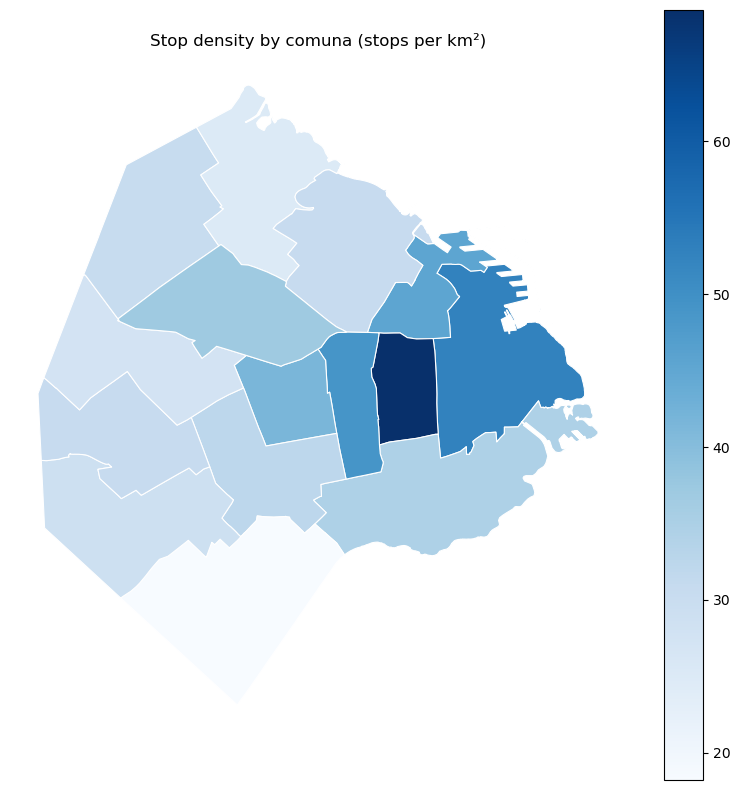

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

comunas.plot(ax=ax,column="stops_per_km2",cmap="Blues",edgecolor="white",linewidth=0.8,legend=True)
ax.set_title("Stop density by comuna (stops per km²)")
ax.set_axis_off()
plt.tight_layout()

This histogram shows the distribution of stop density across comunas. Although the number of comunas is small, this view helps illustrate overall variability.

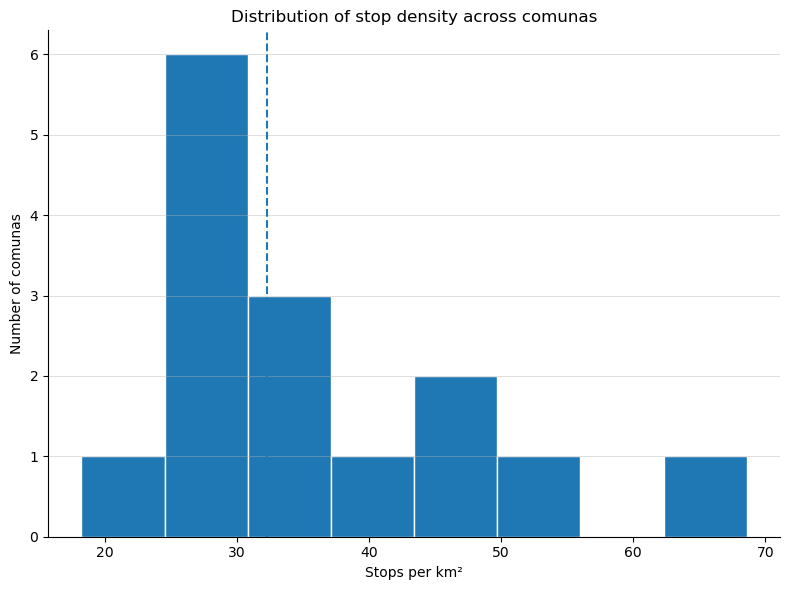

In [60]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(comunas["stops_per_km2"], bins=8, edgecolor="white")
plt.axvline(comunas["stops_per_km2"].median(), linestyle="--")
plt.title("Distribution of stop density across comunas")
plt.xlabel("Stops per km²")
plt.ylabel("Number of comunas")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", alpha=0.4)
plt.tight_layout()

#### 4.2.2 Stops density by barrio

Finally, I compute density at the barrio level. Since barrios vary widely in area, this metric can reshuffle the ranking compared to raw counts. I use a top/bottom view and a distribution plot to spot typical values and potential outliers.

In [27]:
barrios["stops_per_km2"] = barrios["n_stops"] / barrios["area_km2"]
(
    barrios[["nombre","area_km2","n_stops","stops_per_km2"]]
    .sort_values(by="stops_per_km2",ascending=False)
    .head(10)
)

,nombre,area_km2,n_stops,stops_per_km2
11,CONSTITUCION,2.101995,221.0,105.138204
16,MONSERRAT,2.198622,180.0,81.869456
2,BALVANERA,4.342281,328.0,75.536342
28,RETIRO,4.514378,258.0,57.150734
32,SAN TELMO,1.232270,66.0,53.559679
1,ALMAGRO,4.050753,210.0,51.842218
8,CHACARITA,3.115707,156.0,50.068886
27,RECOLETA,6.433406,300.0,46.631595
24,PARQUE PATRICIOS,3.743440,167.0,44.611369
6,BOEDO,2.609851,112.0,42.914325


In [28]:
(
    barrios[["nombre","area_km2","n_stops","stops_per_km2"]]
    .sort_values(by="stops_per_km2",ascending=False)
    .tail(10)
)

,nombre,area_km2,n_stops,stops_per_km2
38,VILLA GRAL MITRE,2.162275,0.0,0.0
39,VILLA LUGANO,9.296143,0.0,0.0
40,VILLA LURO,2.566937,0.0,0.0
41,VILLA ORTUZAR,1.853802,0.0,0.0
42,VILLA PUEYRREDON,3.303240,0.0,0.0
43,VILLA REAL,1.334146,0.0,0.0
44,VILLA RIACHUELO,4.239850,0.0,0.0
45,VILLA SANTA RITA,2.153691,0.0,0.0
46,VILLA SOLDATI,8.690726,0.0,0.0
47,VILLA URQUIZA,5.449059,0.0,0.0


This bar chart shows stop density at the barrio level. Since barrios vary widely in size, this metric helps identify neighborhoods with particularly high or low stop coverage relative to their area.

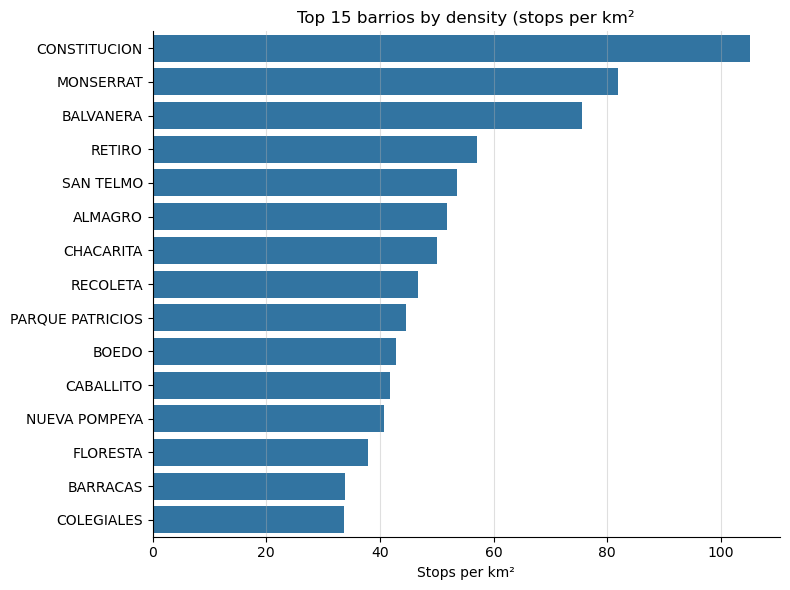

In [59]:
top_n = 15
barrios_plot = barrios.copy().sort_values(by="stops_per_km2",ascending=False).head(top_n)
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(ax=ax, data=barrios_plot, x="stops_per_km2", y="nombre")
plt.title(f"Top {top_n} barrios by density (stops per km²")
plt.xlabel("Stops per km²")
plt.ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", alpha=0.4)
plt.tight_layout()


This map displays stop density by barrio (stops per km²), offering a more detailed view of local variations in stop density.

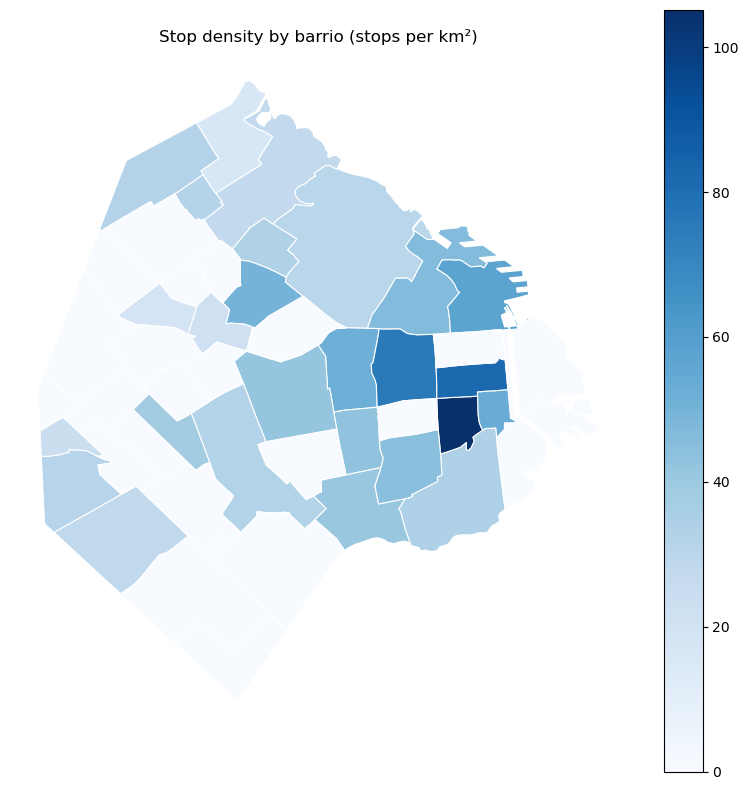

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

barrios.plot(ax=ax,column="stops_per_km2",cmap="Blues",edgecolor="white",linewidth=0.8,legend=True)
ax.set_title("Stop density by barrio (stops per km²)")
ax.set_axis_off()
plt.tight_layout()

This plot shows the distribution of stop density values across barrios. It helps identify the typical range of densities as well as potential outliers.

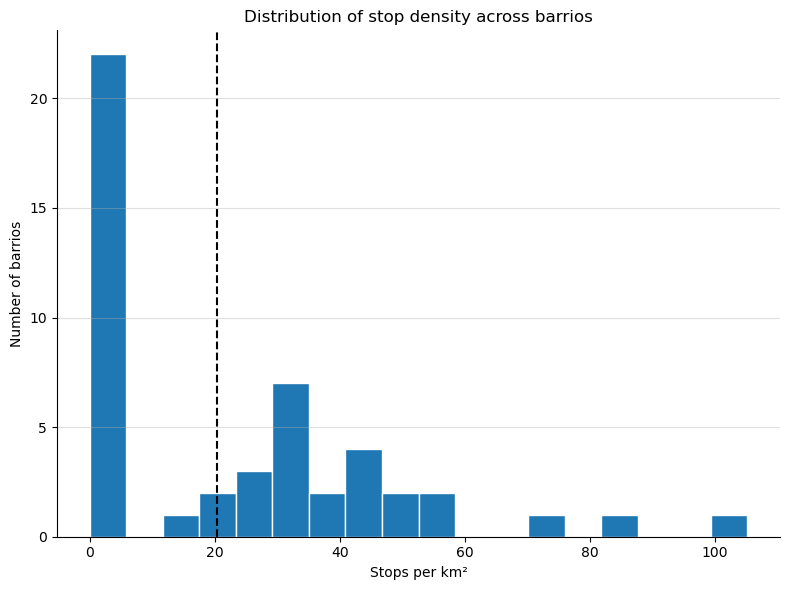

In [58]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(barrios["stops_per_km2"], bins=18, edgecolor="white")
plt.title("Distribution of stop density across barrios")
plt.axvline(barrios["stops_per_km2"].median(), linestyle="--", color="Black")
plt.xlabel("Stops per km²")
plt.ylabel("Number of barrios")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", alpha=0.4)
plt.tight_layout()

### 4.3 Observations

Looking at the horizontal bar charts, it is clear that raw stop counts and stop density lead to different rankings. Barrios and comunas that appear at the top when using absolute counts do not always remain there once density (stops per km²) is considered.

The choropleth maps reinforce this pattern visually: areas with high stop density tend to be more spatially concentrated, while larger administrative units often show moderate densities despite having many stops in total.

This difference becomes more evident in the histograms. At the barrio level, stop density shows a right-skewed distribution, with most barrios clustered around a typical range and a small number of high-density outliers. In contrast, the comuna-level histogram is more compact, indicating lower variability at this aggregated scale. This pattern suggests that median values are more representative than the mean when describing a barrio.

## 5. Streets with most stops

This section identifies the streets with the highest number of bus stops, based on a simple count of stops per street.
Since longer avenues naturally accumulate more stops, this metric reflects concentration rather than density.

In [46]:
stops_by_calle = stops.groupby("calle").size().rename("n_stops").sort_values(ascending=False).reset_index()

stops_by_calle.head(15) 


,calle,n_stops
0,AV RIVADAVIA,281
1,AV FE SANTA,129
2,AV CORRIENTES,108
3,AV EVA PERON,105
4,AV CABILDO,100
5,AV GENERAL HERAS LAS,98
6,AV PUEYRREDON,92
7,AV CORDOBA,74
8,AV GRAL PAZ,72
9,ALBERDI AV BAUTISTA JUAN,67


The figure ranks streets by the total number of bus stops, providing a straightforward view of stop concentration at the street level.

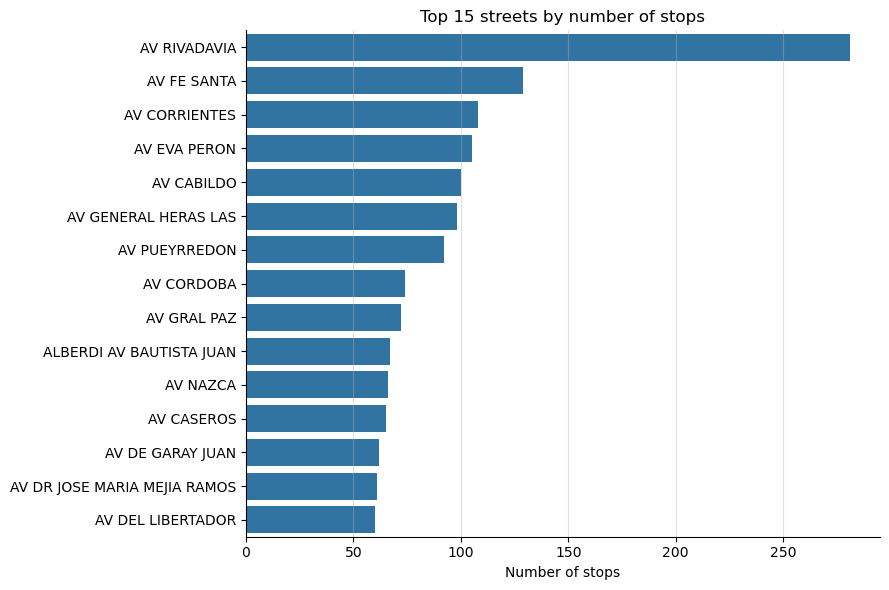

In [67]:
top_n = 15
stops_by_calle_plot = stops_by_calle.head(top_n)

fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(ax=ax, data=stops_by_calle_plot, x="n_stops", y="calle")
plt.title(f"Top {top_n} streets by number of stops")
plt.xlabel("Number of stops")
plt.ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", alpha=0.4)

plt.tight_layout()


This map contextualizes the streets with the highest number of stops within the urban layout of the city. This visualization complements the ranking by linking numerical counts with their geographic location.

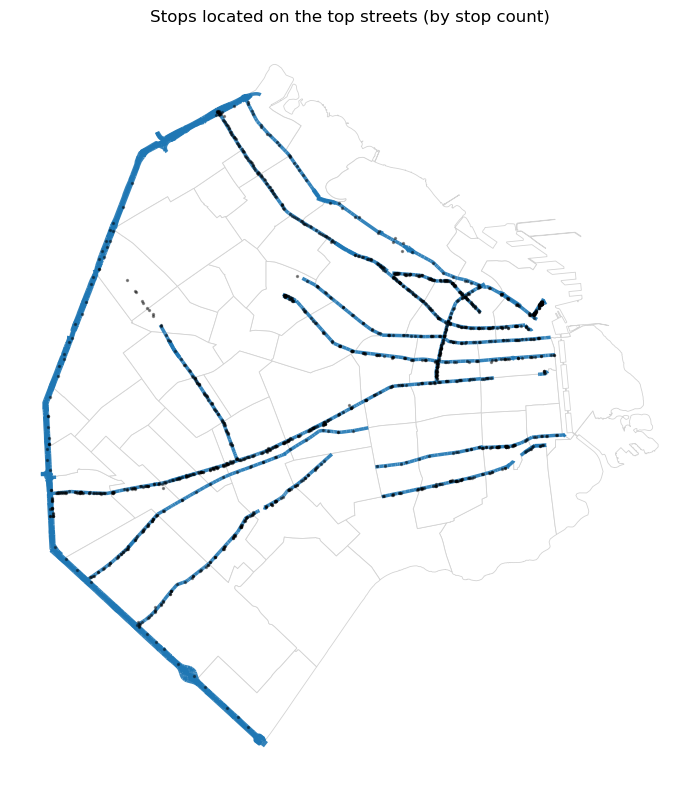

In [77]:
top_streets = stops_by_calle.head(15)["calle"].tolist()

streets_top = calles[calles["calle"].isin(top_streets)].copy()
stops_top = stops[stops["calle"].isin(top_streets)].copy()

fig, ax = plt.subplots(figsize=(8, 8))
barrios.plot(ax=ax, color="white", edgecolor="lightgray", linewidth=0.6, zorder=1)

streets_top.plot(ax=ax, linewidth=2.5, alpha=0.9, color="C0",zorder=2)
stops_top.plot(ax=ax, markersize=2, alpha=0.4, color="Black", zorder=3)

ax.set_title("Stops located on the top streets (by stop count)")
ax.set_axis_off()
plt.tight_layout()


The map shows that streets with the highest number of stops correspond to long, highly connected avenues that traverse large portions of the city.

## 6. Lines & Coverage